In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
data = pd.read_excel("./data/Исходник_для_аномалий.xlsx", decimal=".")
columns = ["WWPR", "WOPR", "WGPR", "WBHP", "WTHP", "WGIR", "WWIR"]
for c in columns + ["WEFAC"]:
    if data[c].dtype == "O":
        data[c] = pd.Series(
            data[c].astype(str).apply(lambda x: x.replace(",", ".")).astype("float64")
        )
data["WLPROD"] = (data["WWPR"] + data["WOPR"]) / (180 - data["WBHP"])
data["WWPROD"] = (data["WWPR"]) / (180 - data["WBHP"])
data["WOPROD"] = (data["WOPR"]) / (180 - data["WBHP"])
data["GOR"] = (data["WGPR"]) / (data["WOPR"])
data

,WELL,DATE,WWPR,WOPR,WGPR,WBHP,WTHP,WGIR,WWIR,WEFAC,WLPROD,WWPROD,WOPROD,GOR
0,1,2017-09-12,0.0,0.0,0.0,0.0,139.16,0.0,0,1.0,0.0,0.0,0.0,NaN
1,1,2017-09-13,0.0,0.0,0.0,0.0,138.18,0.0,0,1.0,0.0,0.0,0.0,NaN
2,1,2017-09-14,0.0,0.0,0.0,0.0,138.18,0.0,0,1.0,0.0,0.0,0.0,NaN
3,1,2017-09-15,0.0,0.0,0.0,0.0,136.22,0.0,0,1.0,0.0,0.0,0.0,NaN
4,1,2017-09-16,0.0,0.0,0.0,0.0,136.22,0.0,0,1.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144338,134,2021-12-27,0.0,0.0,550560.0,0.0,0.00,0.0,0,1.0,0.0,0.0,0.0,inf
144339,134,2021-12-28,0.0,0.0,166773.0,0.0,0.00,0.0,0,1.0,0.0,0.0,0.0,inf
144340,134,2021-12-29,0.0,0.0,462300.0,0.0,0.00,0.0,0,1.0,0.0,0.0,0.0,inf
144341,134,2021-12-30,0.0,0.0,633745.0,0.0,118.00,0.0,0,1.0,0.0,0.0,0.0,inf


In [22]:
data = data[data.WELL==13]
data = data.iloc[480:550]

In [112]:
def highlight_points_on_lineplot(data, x, y, points, marker='o', color='red'):
    data = data.copy(deep=True)
    # Строим график линии
    sns.lineplot(x=x, y=y, data=data)
    # Добавляем маркеры для каждой выбранной точки
    data = data[points]
    for point in data[x]:
        plt.plot(point, data.loc[data[x]==point, y], marker=marker, color=color)
    # Отображаем график
    plt.show()

import numpy as np
from sklearn.cluster import DBSCAN

def find_group_outliers(arr, eps=0.5, min_samples=5):
    # Создаем объект DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # Преобразуем массив в двумерный формат
    X = arr.reshape(-1, 1)
    # Обучаем модель
    dbscan.fit(X)
    # Находим номера кластеров
    labels = dbscan.labels_-np.min(dbscan.labels_)
    # Находим номер кластера, содержащего наибольшее количество точек
    largest_cluster = np.argmax(np.bincount(labels))
    # Находим индексы точек, которые не принадлежат этому кластеру
    outliers = labels != largest_cluster
    return outliers

def find_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers


from sklearn.ensemble import IsolationForest

def find_outliers_trend(data):
    # Разбиваем данные на обучающую и тестовую выборки
    n = len(data)
    train_size = int(0.8 * n)
    X_train = np.arange(train_size).reshape(-1, 1)
    y_train = data[:train_size]
    X_test = np.arange(train_size, n).reshape(-1, 1)
    y_test = data[train_size:]
    
    # Обучаем модель Isolation Forest
    model = IsolationForest(contamination='auto', random_state=42)
    model.fit(X_train, y_train)
    
    # Предсказываем аномальные значения в тестовой выборке
    y_pred = model.predict(X_test)
    outliers = y_pred == -1
    
    return outliers

import numpy as np
from sklearn.ensemble import IsolationForest

def find_outliers_trend(data):
    # Разбиваем данные на обучающую и тестовую выборки
    n = len(data)
    train_size = int(0.8 * n)
    X_train = np.arange(train_size).reshape(-1, 1)
    y_train = data[:train_size]
    X_test = np.arange(train_size, n).reshape(-1, 1)
    y_test = data[train_size:]
    
    # Обучаем модель Isolation Forest
    model = IsolationForest(contamination='auto')
    model.fit(X_train, y_train)
    
    # Предсказываем аномальные значения в тестовой выборке
    y_pred = model.predict(data.reshape(-1, 1))
    outliers = y_pred == -1
    
    return outliers

from sklearn.neighbors import LocalOutlierFactor

def find_outliers_lof(data, n=5):
    lof = LocalOutlierFactor(n_neighbors=n)
    outliers = lof.fit_predict(data.reshape(-1, 1))
    return outliers == -1

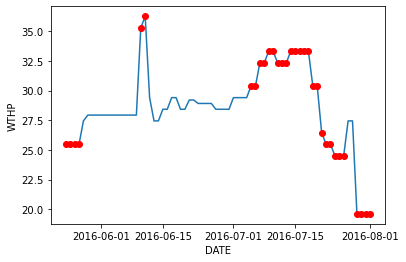

In [107]:
column = 'WTHP'
points = find_group_outliers(data2[column].to_numpy())
highlight_points_on_lineplot(data2, 'DATE', column, points)

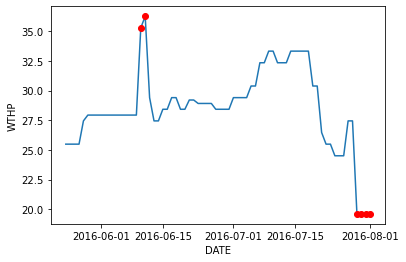

In [108]:
column = 'WTHP'
points = find_outliers(data2[column].to_numpy())
highlight_points_on_lineplot(data2, 'DATE', column, points)

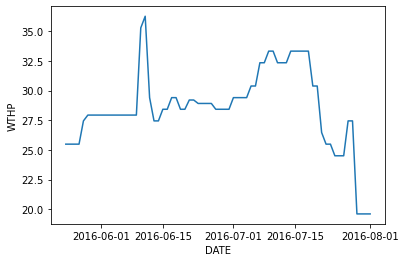

In [109]:
column = 'WTHP'
points = find_outliers_trend(data2[column].to_numpy())
highlight_points_on_lineplot(data2, 'DATE', column, points)

## LOF -- norm rabotaet

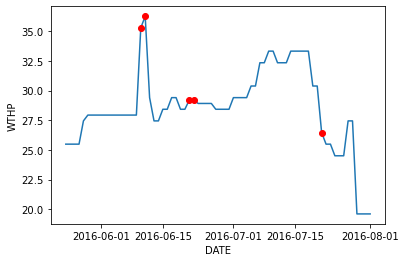

In [118]:
column = 'WTHP'
points = find_outliers_lof(data2[column].to_numpy(), n=2)
highlight_points_on_lineplot(data2, 'DATE', column, points)

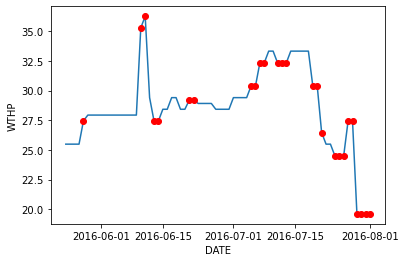

In [114]:
column = 'WTHP'
points = find_outliers_lof(data2[column].to_numpy(), n=5)
highlight_points_on_lineplot(data2, 'DATE', column, points)

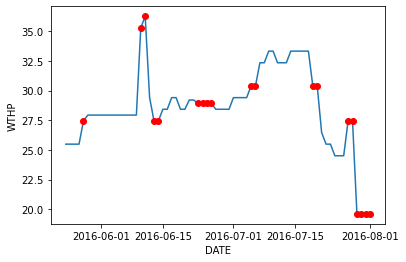

In [115]:
column = 'WTHP'
points = find_outliers_lof(data2[column].to_numpy(), n=7)
highlight_points_on_lineplot(data2, 'DATE', column, points)

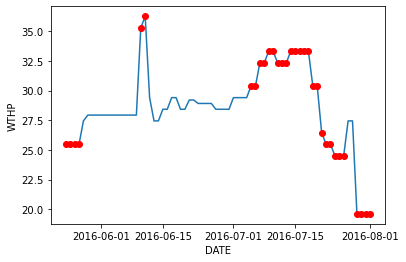

In [116]:
column = 'WTHP'
points = find_outliers_lof(data2[column].to_numpy(), n=20)
highlight_points_on_lineplot(data2, 'DATE', column, points)

### change of trend

In [126]:
# import numpy as np

# def find_trend_change(data, window_size=10, threshold=0.05):
#     # Считаем скользящие средние
#     ma1 = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
#     ma2 = np.convolve(ma1, np.ones(window_size)/window_size, mode='valid')
#     print(len(data), len(ma1), len(ma2))
#     # Вычисляем разницу между скользящими средними
#     diff = np.abs(ma1[1:] - ma2[:-1])
    
#     # Находим точки, где разница превышает пороговое значение
#     change_points = diff > threshold
#     return change_points
# # [False for _ in range(window_size-1)]+list(diff > threshold)

In [147]:
import numpy as np
from sklearn.linear_model import LinearRegression

def find_trend_change_points_lr(data, threshold=0.4):
    indexes = np.full(len(data), False)
    x = np.arange(len(data)).reshape(-1, 1)
    prev_model = LinearRegression().fit(x[:2], data[:2])
    for i in range(2, len(data)):
        model = LinearRegression().fit(x[:i], data[:i])
        if np.abs(model.coef_ - prev_model.coef_) > threshold*np.abs(prev_model.coef_):
            indexes[i-1]=True
            prev_model = model
    return indexes


def find_trend_change_points_slide(data, window_size=5, threshold=0.5):
    ma1 = np.convolve(data, np.ones(window_size)/window_size, mode='same')
    ma2 = np.convolve(data, np.ones(2*window_size+1)/(2*window_size+1), mode='same')
    diff = np.abs(ma1 - ma2)
    change_points = diff > threshold
    return change_points

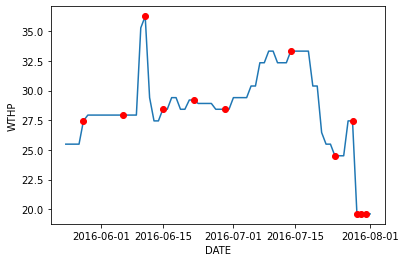

In [143]:
column = 'WTHP'
points = find_trend_change_points_lr(data2[column].to_numpy())
# print(points)
highlight_points_on_lineplot(data2, 'DATE', column, points)

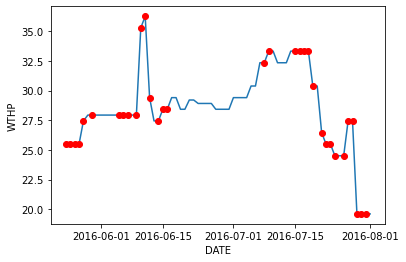

In [146]:
column = 'WTHP'
points = find_trend_change_points_slide(data2[column].to_numpy())
# print(points)
highlight_points_on_lineplot(data2, 'DATE', column, points)

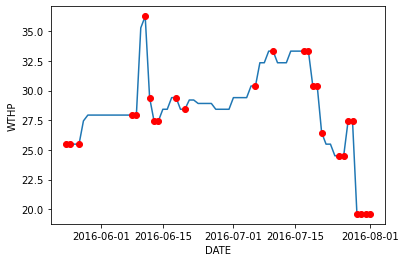

In [150]:
column = 'WTHP'
points = find_trend_change_points_slide(data2[column].to_numpy(), window_size=2)
# print(points)
highlight_points_on_lineplot(data2, 'DATE', column, points)

## Нахождение всех ПЛАТО

In [155]:
import numpy as np

def change_false_to_true(array):
    for i in range(len(array)-1):
        if array[i] == False and array[i+1] == True:
            array[i] = True
    return array

def find_plateau_positions(data):
    diffs = np.abs(np.diff(data))
    plateau_positions = [False]+list(diffs == 0)
    return change_false_to_true(plateau_positions)

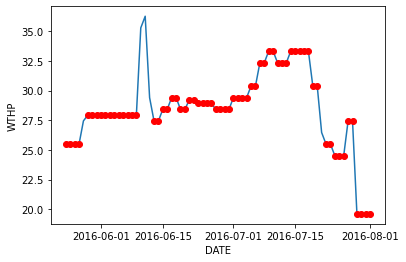

In [156]:
column = 'WTHP'
points = find_plateau_positions(data2[column].to_numpy())
# print(points)
highlight_points_on_lineplot(data2, 'DATE', column, points)

## нахождение всех нулей

In [157]:
def find_zeros(data):
    plateau_positions = list(data == 0)
    return plateau_positions

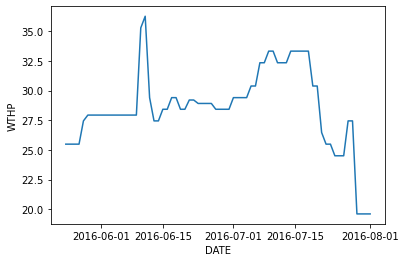

In [158]:
column = 'WTHP'
points = find_zeros(data2[column].to_numpy())
# print(points)
highlight_points_on_lineplot(data2, 'DATE', column, points)